# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.01
dynamics = InvertedPendulumDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))

Q = np.array([[100.0, 0.0, 0.0], [0.0, 100.0, 0.0], [0.0, 0.0, 1.0]])
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[1.0]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 600

x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 240151.7844599118 [-3.09873225  0.141854  ]
iteration 1 accepted 239667.06377798377 [-3.08118376  0.20444823]
iteration 2 accepted 238278.88516621306 [-3.03562953  0.38970972]
iteration 3 accepted 234542.89991770845 [-2.92234921  0.82945039]
iteration 4 accepted 225648.93530762324 [-2.69772613  1.68408375]
iteration 5 accepted 219556.83980975262 [3.03550375 5.13822886]
iteration 6 accepted 217162.9941142595 [2.2498244  4.51666635]
iteration 7 accepted 209073.95635217722 [ 0.38021835 -1.24909985]
iteration 8 accepted 200634.02110757274 [ 0.38500289 -1.70080514]
iteration 9 accepted 193862.5010557455 [ 2.12785807 -6.19103551]
iteration 10 accepted 183730.32011027756 [ 2.81376623 -6.98198023]
iteration 11 accepted 174268.2777035203 [-2.11610305 -6.09365351]
iteration 12 accepted 164615.81101270503 [0.42985285 1.86886767]
iteration 13 accepted 163456.37511359144 [0.88123891 2.97970947]
iteration 14 accepted 161207.5904546074 [0.42480729 1.22214186]
iteration 15 accepte

iteration 126 accepted 153503.42490875113 [0.07762499 0.24168426]
iteration 127 accepted 153495.54874949067 [0.08561019 0.27208444]
iteration 128 accepted 153455.7673791016 [0.07830614 0.23805694]
iteration 129 accepted 153454.70108103575 [0.07308667 0.23017712]
iteration 130 accepted 153435.4073956773 [0.13104756 0.41302057]
iteration 131 accepted 153419.92357955748 [0.07447476 0.20970314]
iteration 132 accepted 153396.7600133036 [0.07437243 0.2095588 ]
iteration 133 accepted 153385.67593427905 [0.0588315  0.16584232]
iteration 134 accepted 153355.48169624727 [0.1172064  0.35389031]
iteration 135 accepted 153349.85731694152 [0.06705658 0.17326516]
iteration 136 accepted 153325.53296422365 [0.09127373 0.25300697]
iteration 137 accepted 153260.01859451292 [0.07795915 0.1977065 ]
iteration 138 accepted 153258.99411705654 [0.06368058 0.16935375]
iteration 139 accepted 153242.14023058477 [0.11936936 0.37107896]
iteration 140 accepted 153225.86375838154 [0.11699455 0.30016748]
iteration 141

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

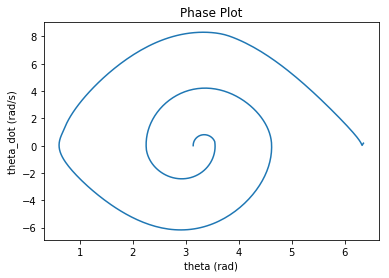

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

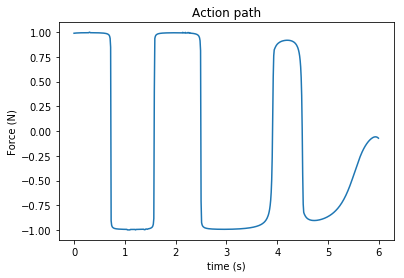

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

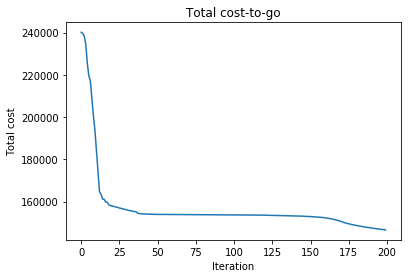

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")